<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial X </h1>
    <h2> Design Optimisation with Metamodels </h2>
</div>

# Overview

Overview goes here.

## Recommended reading

* First item
* Second item

<hr>

<div style="background-color: #e6ccff; padding: 10px;">

<h1> Machine Learning Theory </h1>

# Design Optimisation

## The problem

Summary of design optimisation problem and introduction to metamodels

## Popular metamodels

* Metamodel 1
* Metamodel 2

## Coronary bypass anastomosis angle optimisation problem

Problem exposition goes here

<div style="background-color: #cce5ff; padding: 10px;">

# Python

## [Library 1](https://pytorch.org/)

PyTorch is an open-source machine learning library developed by Facebook's AI Research lab. It is widely used for applications such as natural language processing and computer vision. PyTorch is known for its flexibility and ease of use, particularly due to its dynamic computation graph, which allows for more intuitive model building and debugging. However, it is considered quite low-level compared to some other frameworks (e.g. [Keras](https://keras.io/)), meaning that defining complex models like a U-Net can require a significant amount of verbose code. This verbosity can make the development process more cumbersome, especially for those who are new to deep learning.

## [Library 2](https://www.fast.ai/)

fastai is a high-level library built on top of PyTorch that simplifies the process of training deep learning models. It provides a range of pre-built functions and classes that allow users to leverage the powerful capabilities of PyTorch without needing to write extensive amounts of code. With fastai, you can define and train complex models, such as U-Nets, in just a few lines of code. This makes it an excellent choice for both beginners and experienced practitioners who want to quickly prototype and experiment with different models while still benefitting from the flexibility and performance of PyTorch under the hood.

## Further reading

If you want to run this notebook locally or on a remote service:

* [running Jupyter notebooks](https://jupyter.readthedocs.io/en/latest/running.html)
* [installing the required Python environments](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/blob/main/howtorun.md)
* [running the Jupyter notebooks locally](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/blob/main/jupyter_notebooks.md)

</div>

<hr>

<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

This notebook should run with the following requirements satisfied.

<h2> Python Packages: </h2>

* fenics
* mshr
* numpy
* scipy
* matplotlib
* notebook
* pysgpp

<h2> Data Requirements</h2>

This notebook is self contained with respect to data as everything is generated from simulations within the notebook.

</div>

**Contents:**

1. [Overview and machine-learning theory](#Overview)
2. [Application to self-driving cars](#Application-to-self-driving-cars)
3. [Application to detection of lee waves](#Application-to-detection-of-lee-waves)

<div style="background-color: #cce5ff; padding: 10px;">

## Import modules

These are all the modules needed during this tutorial.

</div>

In [ ]:
import random
import mshr
import pysgpp
import logging
logging.getLogger('FFC').setLevel(logging.WARNING) # instantiate logger object

import numpy as np
import matplotlib.pyplot as plt

from dolfin import *
from math import pi, floor, sin
from scipy.stats import qmc
from scipy.interpolate import RBFInterpolator
from scipy.optimize import minimize, Bounds, SR1

# DESIGN OPTIMISATION WITH METAMODELS

**Prerequisites:**

Install the finite element library FEniCS.

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

Install the sparse grid approximation toolkit SG++ (https://sgpp.sparsegrids.org/).

In [ ]:
!pip install pysgpp

Other libraries required: NumPy, SciPy, matplotlib

---


**Coronary bypass anastomosis angle optimisation problem:**

In this notebook, we solve a design optimisation problem in a PDE-constrained framework using metamodels. The motivation of this problem is the optimal design of coronary artery bypass graft (for more details, see: [5]).

The goal is to optimise the angle $\theta$ that a bypass graft anastomosis  makes with the parent vessel:

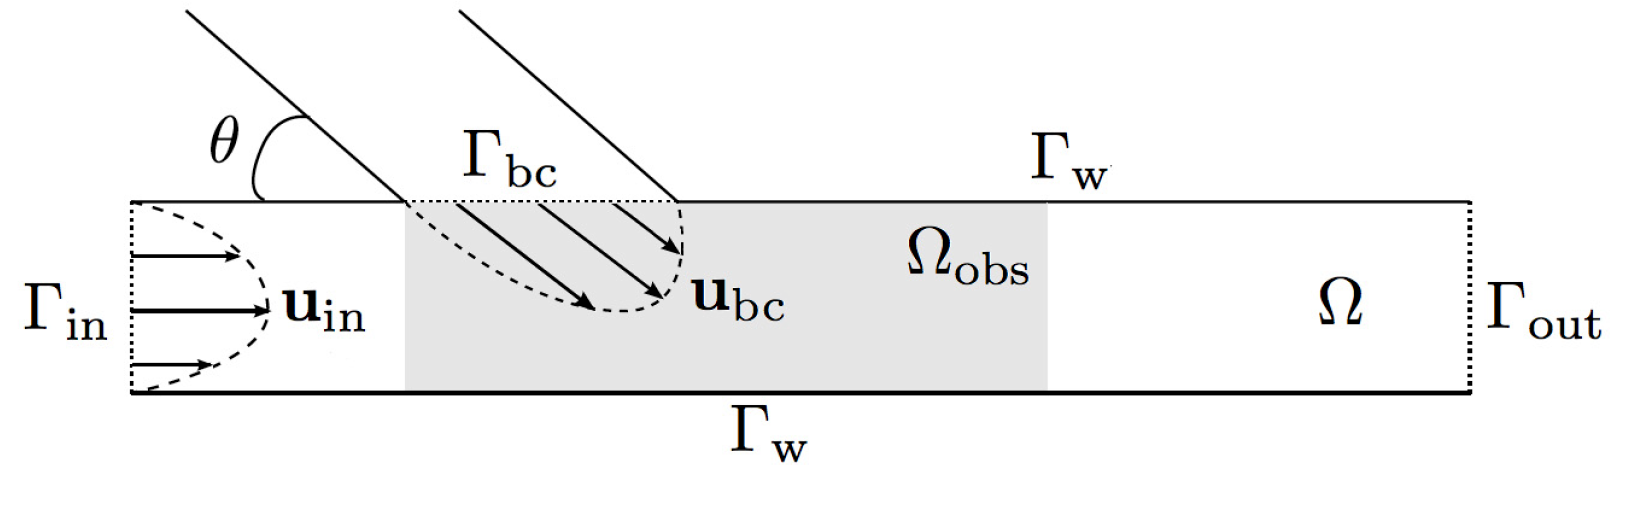

Blood flow is modelled with the incompressible laminar Navier-Stokes equations: find $(u,p)$ such that
$$
\begin{aligned}
  -\nu \triangle u + (u \cdot \nabla)u + \frac{1}{\rho} \nabla p &= 0 & \textrm{ in } \Omega \\
  \nabla \cdot u &= 0 & \textrm{ in } \Omega
\end{aligned}.
$$

The anastomosis is not modelled as part of the vessel geometry, and is instead modelled as a boundary condition depending on the angle $\theta$. Thus the computational domain is the rectangle, $\Omega = (0,5) \times (0,1)$. The boundary conditions are defined as:

$$
\begin{aligned}
u = u_{in} &= 6 \omega (1-x_2)x_2 \boldsymbol{e}_1 \quad &\textrm{ on } \Gamma_{in} \\
u = u_{bc} &= \frac{2(1-\omega)}{\tan \theta} \boldsymbol{e}_1 - 2(1-\omega) \boldsymbol{e}_2 \quad &\textrm{ on } \Gamma_{bc}\\
p &= 0 &\textrm{ on } \Gamma_{out} \\
u &= 0 &\textrm{ on } \Gamma_{w}.
\end{aligned}
$$

This implies no-slip boundary conditions at the walls, a parabolic inlet velocity in the parent vessel, a plug flow inlet velocity depending on the anastomosis angle $\theta$, and zero-pressure at the outlet.

The total inflow is scaled to be equal to $100\% \times \textrm{Re}$, where $\omega \,\textrm{Re}$ comes from the parent vessel and $(1-\omega) \textrm{Re}$ comes from the anastomosis, and $\textrm{Re}$ is the target Reynolds number (between 100-200 in the real coronary artery). Thus the model can be used to explore the effect of different levels of stenosis severity on the optimal design by varying $\omega \in (0,1)$.

---

**Fluid problem solution:**

To solve the Navier-Stokes equations, we use the finite element package FEniCS:

In [ ]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
import numpy as np
from math import pi

def build_FE_space(theta, omega):

    # Define physical parameters of flow problem
    mu = 0.035      # dynamic viscosity (value for blood)
    rho = 1.060     # density (value for blood)
    Re = 90         # desired Reynolds number for pipe flow (biological Re is between 100-200 in coronary arteries)

    # Define computational domain
    L = 5.0
    W = 1.0
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W))

    # Build mesh
    mesh = mshr.generate_mesh(geometry, 64)

    # Build function spaces (Taylor-Hood P2/P1 elements)
    P2 = VectorElement("P", mesh.ufl_cell(), 2)
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)
    TH = MixedElement([P2, P1])
    W = FunctionSpace(mesh, TH)

    # Define the subdomain \Omega_obs and its complement
    class OmegaObs(SubDomain):
      def inside(self, x, on_boundary):
          return True if (x[0] >= 1 and x[0] <= 4) else False
    class OmegaRest(SubDomain):
      def inside(self, x, on_boundary):
          return True if (x[0] <= 1 or x[0] >= 4) else False

    subdomains = MeshFunction('size_t', mesh, mesh.topology().dim())
    subdomain0 = OmegaObs()
    subdomain0.mark(subdomains, 0)
    subdomain1 = OmegaRest()
    subdomain1.mark(subdomains, 1)

    # Define an indicator function for \Omega_obs
    V0 = FunctionSpace(mesh, 'DG', 0)
    IF_OmegaObs = Function(V0)
    IF_values = [1.0, 0.0]

    for cell_no in range(len(subdomains.array())):
      subdomain_no = subdomains.array()[cell_no]
      IF_OmegaObs.vector()[cell_no] = IF_values[subdomain_no]

    # Define boundaries
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 5.0)'
    bottom   = 'near(x[1], 0)'
    top      = 'near(x[1], 1) && ((x[0]<1.0) || (x[0]>1.5))'
    anastomosis = 'near(x[1], 1) && ((x[0]>1.0) && (x[0]<1.5))'

    # Scale flow appropriately to the Reynolds number
    ReMultiplier = Re / (rho/mu)

    # Define parabolic inflow profile
    inflow_profile = (str(omega * ReMultiplier) + '*6*x[1]*(1-x[1])', '0')

    # Define anastomosis inflow profile parameterised by angle
    anastomosis_profile = (str((1-omega)*ReMultiplier) +'*2/tan(' + str(theta * 2*pi/360) + ')', '-2*' + str((1-omega)*ReMultiplier))

    # Define boundary conditions
    bcu_inflow      = DirichletBC(W.sub(0), Expression(inflow_profile, degree=2), inflow)
    bcu_anastomosis = DirichletBC(W.sub(0), Expression(anastomosis_profile, degree=2), anastomosis)
    bcu_bottom      = DirichletBC(W.sub(0), Constant((0, 0)), bottom)
    bcu_top         = DirichletBC(W.sub(0), Constant((0, 0)), top)
    bcp_outflow     = DirichletBC(W.sub(1), Constant(0), outflow)
    bcs             = [bcu_inflow, bcu_bottom, bcu_top, bcu_anastomosis, bcp_outflow]

    return W, bcs, IF_OmegaObs


def solve_navier_stokes(W, nu, bcs, IF_OmegaObs):
    """Solve steady Navier-Stokes and return the solution"""

    # Define variational forms
    v, q = TestFunctions(W)
    w = Function(W)
    u, p = split(w)
    F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
        - p*div(v)*dx - q*div(u)*dx

    # Solve the problem
    solve(F == 0, w, bcs)

    # Evaluate the cost functionals in the subdomain \Omega_obs
    energy = IF_OmegaObs * inner(nabla_grad(u), nabla_grad(u))*dx
    E = assemble(energy)

    u, p = split(w)
    vorticity = IF_OmegaObs * inner(curl(u), curl(u))*dx
    V = assemble(vorticity)

    # Plot
    plot(u, title='velocity {}'.format('Velocity'))

    return E, V

def solveAnastomosisProblemNL(theta, omega):
    # Problem data
    nu = Constant(0.035 / 1.060)

    # Discretization parameters
    N_bulk = 64

    # Prepare function space and BCs
    W, bcs, IF_OmegaObs = build_FE_space(theta, omega)

    # Solve Navier-Stokes and evaluate cost functional
    E, V = solve_navier_stokes(W, nu, bcs, IF_OmegaObs)

    return V

In [ ]:
solveAnastomosisProblemNL(60, 0.3)

Depending on the value of the flow split parameter $\omega\in[0,1]$ and the Reynolds number $Re$, the entering flow jet  causes a recirculation region (vortex) to appear slightly before the anastomosis.

---

**Design optimisation problem formulation:**

Different cost functionals can be chosen for the design optimisation problem. The most common choice is to minimise the $H^1$ semi-norm of the solution:
$$
E(u(\theta)):= \int_{\Omega} |∇ u|^2 \: dx = \int_{\Omega} \nabla u \cdot \nabla u \: dx.
$$
This can be understood as minimising the viscous energy dissipation of the flow. A more biologically focused choice is to minimise the vorticity:
$$
V(u(\theta)):= \int_{\Omega} |∇ \times u|^2 \: dx.
$$
The motivation for this functional is that the endothelial cells lining blood vessels react to shear forces induced by the flow. If the flow is disturbed or stagnant near the vessel walls, it triggers an inflammatory pathway that can result in further atherosclerosis. Therefore, it is important to minimise the presence of large vortices since they are connected to flow stagnation regions near the walls.

To optimise the anastomosis angle for a single $\omega$, we look for the solution $\theta^*$ that minimises

$$
\theta^* := \textrm{argmin}_{\theta} \{ V(u(\theta;\omega)) \}
$$

subject to

$$
\begin{aligned}
  F(u(\theta;\omega)) &= 0 \quad & \textrm{(Navier-Stokes equations)} \\
  \theta &\leq \theta_{max} & \textrm{(maximum anastomosis angle)}\\
  \theta &\geq \theta_{min} & \textrm{(minimum anastomosis angle)}
\end{aligned}.
$$

This is a constrained minimisation problem, where each evaluation of the functional $E$/$V$ requires a PDE solution.

---

**Metamodel formulation:**

Since evaluation of the cost functionals $E(u)$ and $V(u)$ requires solving the Navier-Stokes equations and evaluation of their gradients $\nabla_u E(u)$ and $\nabla_u V(u)$ requires solving the adjoint equations, these problems are computationally expensive. We thus look for computationally efficient metamodels to approximate the parametric cost functions $\theta \mapsto E(u(\theta))$ and $\theta \mapsto V(u(\theta))$.

Let $\{(\theta_i,\omega_i)\}_{i=1}^{N_s}$ be a finite sample of parameter points from the parametric design space $[\theta_{min},\theta_{max}] \times [\omega_{min},\omega_{max}]$. Then for each sample point $(\theta_i,\omega_i)$, we compute the correspond values of $E(u(\theta_i,\omega_i))$ and $V(u(\theta_i,\omega_i))$. This requires $N_s$ PDE solves.

 In this example, we implement four different approaches to constructing a meta-model.
1.   Radial basis function -interpolation on a regular grid
2.   Radial basis function -interpolation on a random sequence of points
3.   Radial basis function -interpolation on a Halton sequence of points
4.   Smolyak sparse grid interpolation

In [ ]:
#metaModel = "RBFInterpolation/RegularGrid"
#metaModel = "RBFInterpolation/RandomPoints"
metaModel  = "RBFInterpolation/HaltonSequence"
#metaModel = "SmolyakInterpolation"

For better comparison, we constrain each of these methods to operate on a sample of 49 points. In higher-dimensional problems, the number of samples required may grow exponentially in the number of parameters $D$ (curse of dimensionality).

Once the interpolation points have been fixed, the PDE needs to be solved for each point in the parameter space to obtain snapshot solutions.

In [ ]:
import random
from scipy.stats import qmc
import pysgpp
from math import floor, pi, sin

Ns = 49

snapshots = np.empty((Ns, 3))

# Create parametric sample of Ns points in 2-dimensional parameter space
match metaModel:
  case "RBFInterpolation/HaltonSequence":
    HaltonSampler = qmc.Halton(d=2, scramble=False)
    HaltonSample = HaltonSampler.random(n=Ns)

  case "SmolyakInterpolation":
    dim = 2
    level = 3
    # Use Clenshaw-Curtis points including the boundary on [0,1]^2
    grid = pysgpp.Grid.createLinearClenshawCurtisBoundaryGrid(dim)
    gridStorage = grid.getStorage()
    grid.getGenerator().regular(level)
    print("number of grid points:  {}".format(gridStorage.getSize()))

# Call the PDE solver to compute snapshot solutions for bulding a metamodel
for n in range(Ns):
  match metaModel:
    case "RBFInterpolation/RegularGrid":
      idx = float(n % 7) / 6.0
      jdx = float(floor(float(n / 7.0))) / 6.0
      theta = idx * 40. + 30.
      omega = jdx * 0.5 + 0.3

    case "RBFInterpolation/RandomPoints":
      theta = random.random() * 40 + 30   # Create random angle between 30 and 70 degrees
      omega = random.random() * 0.5 + 0.3 # Create random flow split between 30% and 80%

    case "RBFInterpolation/HaltonSequence":
      theta = HaltonSample[n,0] * 40 + 30
      omega = HaltonSample[n,1] * 0.5 + 0.3

    case "SmolyakInterpolation":
      gp = gridStorage.getPoint(n)
      theta = gp.getStandardCoordinate(0) * 40 + 30
      omega = gp.getStandardCoordinate(1) * 0.5 + 0.3

  # Solve the PDE for the values (theta,omega)
  V = solveAnastomosisProblemNL(theta, omega)

  print(' Solved snapshot #' + str(n))
  snapshots[n,0] = theta
  snapshots[n,1] = omega
  snapshots[n,2] = V

After the snapshot solutions have been computed and the respective functional values stored, we can define the functions that evaluate the appropriate response surfaces:

In [ ]:
def ResponseSurfaceRBF(x):
  if (x.ndim != 2):
    x = x.reshape(1,2)

  return (RBFInterpolator(snapshots[:,0:2:1], snapshots[:,2], kernel='inverse_multiquadric', epsilon=0.1, degree=1)(x))

Multi-quadric RBFs are a generally good choice for robust interpolation, as long as the scaling parameter $\varepsilon$ is chosen appropriately.

In [ ]:
def ResponseSurfaceSmolyak(x):
  x = x.reshape(-1,2) # Reshape array in case its shape is (2,:)

  dim = 2
  level = 3
  grid = pysgpp.Grid.createLinearClenshawCurtisBoundaryGrid(dim)
  gridStorage = grid.getStorage()
  grid.getGenerator().regular(level)

  alpha = pysgpp.DataVector(gridStorage.getSize())
  alpha.setAll(0.0)

  for i in range(0, gridStorage.getSize()):
    alpha[i] = snapshots[i,2] # Use pre-computed values

  pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)

  p = pysgpp.DataVector(dim)
  y = np.empty((int(x.size/2), 1))

  for n in range(int(x.size/2)):
    p[0] = (x[n,0] - 30.0) / 40.0
    p[1] = (x[n,1] - 0.3) / 0.5
    opEval = pysgpp.createOperationEvalNaive(grid)
    y[n] = opEval.eval(alpha, p)

  return (y)

Let's plot the response surface:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

xobs = snapshots[:,0:2:1]
yobs = snapshots[:,2]

xgrid = np.mgrid[30:70:50j, 0.3:0.8:50j]
xflat = xgrid.reshape(2, -1).T

if (metaModel == "SmolyakInterpolation"):
  yflat = ResponseSurfaceSmolyak(xflat)
else:
  yflat = ResponseSurfaceRBF(xflat)

ygrid = yflat.reshape(50, 50)

fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=200, vmax=1200, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=10, ec='k', vmin=200, vmax=1200)
fig.colorbar(p)
plt.show()


Depending on the type of interpolant used and the sample points, we find a more-or-less smooth response surface with a peak around $(30,0.3)$. By experimenting with the fluid solutions, we can observe that the anastomotic vortex is at its maximum size when the entry angle is shallow, $\theta=30$, and the residual flow rate from the parent vessel is small, $\omega = 30\%$.

---

**Solving the numerical optimisation problem:**

Now all that remains is to solve the optimal design problem. We start by solving a problem where we assume both the anastomosis angle $\theta$ and the residual flow $\omega$ are controllable.
$$
\min_{\theta,\omega} \tilde{E}(\theta,\omega)
$$
subject to the bound constraints
$
\theta_{\min} \leq \theta \leq \theta_{\max}
$
and
$
\omega_{\min} \leq \omega \leq \omega_{\max}
$. Here $\tilde{E}$ denotes the meta-model we have just constructed. Since the metamodel implicitly includes the PDE evaluation, we don't have further constraints within this formulation.

The metamodel optimisation problem can be solved using scipy.optimize.minimize and a trust-region constrained interior point -algorithm [7]. While we could explicitly derive the metamodel to find the gradient and Hessian matrix for this problem, instead we use a numerical two-point finite difference scheme for the gradient $\nabla \tilde{E}$ and the symmetric rank-1 update formula for the quasi-Newton approximation of the Hessian [8]:

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import SR1

bounds = Bounds([30, 0.3], [70, 0.8])

x0 = np.array([45, 0.4])

if (metaModel == "SmolyakInterpolation"):
  res = minimize(ResponseSurfaceSmolyak, x0, method='trust-constr',  jac="2-point", hess=SR1(), constraints=[], options={'verbose': 1}, bounds=bounds)
else:
  res = minimize(ResponseSurfaceRBF, x0, method='trust-constr',  jac="2-point", hess=SR1(), constraints=[], options={'verbose': 1}, bounds=bounds)

print(res.x)

Despite needing a few hundred quasi-Newton iterations, an optimal design is found within less than a second. The optimal angle is $\theta^*=42.5^{\circ}$ and the optimal residual flow is $\omega^*=76.4\%$.

We can also solve just for the optimal angle $\theta^*$ is the residual flow $\omega$ is known by modifying the bound constraints:

In [ ]:
bounds = Bounds([30, 0.4], [70, 0.4])

x0 = np.array([45, 0.4])

if (metaModel == "SmolyakInterpolation"):
  res = minimize(ResponseSurfaceSmolyak, x0, method='trust-constr',  jac="2-point", hess=SR1(), constraints=[], options={'verbose': 1}, bounds=bounds)
else:
  res = minimize(ResponseSurfaceRBF, x0, method='trust-constr',  jac="2-point", hess=SR1(), constraints=[], options={'verbose': 1}, bounds=bounds)

print(res.x)

Thus for a fixed flow residual $\omega = 40\%$, the optimal angle is now $\theta^*=60.2^{\circ}$.

---

**Exercises:**

**Ex1)** Find the optimal anastomosis angles $\theta^* = \theta^*(\omega)$ as a function of the unknown flow-split parameter $\omega \in (0.3,0.8)$ using a meta-model of your choice and the cost functions $E(u)$ and $V(u)$. Plot the function $\theta^*(\omega)$ for each cost function. What appears to be a robust value for the anastomosis angle assuming we don't know the value of $\omega$?
  
**Ex2)** Many other cost functionals can be used for this optimisation problem. One of them is [6]:

$$
  D(u) = \int_{\Omega} g(\det(\nabla u)) \: dx
$$

where $g(z)$ is a smooth nonnegative function satisfying $g(z)=0$ for $z\leq 0$ and $g(z)=\mathcal{O}(z)$ as $z \to \infty$. This choice is motivated by the fact that vortex cores can be identified as regions where $\nabla u$ has imaginary eigenvalues, see [6].

a)   Prove that the eigenvalues of $\nabla u$ are imaginary iff $\det(\nabla u)> 0$, assuming that the velocity field $u$ is incompressible, $\nabla \cdot u = 0$. Thus the vortex cores of the flow are related points where $\det(\nabla u)> 0$ and minimising $D(u)$ reduces the presence of vortices.

b)   Implement the cost functional $D(u)$ in FEniCS using e.g.
$$g(z)=\left\{
  \begin{aligned}
  0, &\textrm{ if } z<-\delta \\
  \frac{s^2}{2\delta} + s + \frac{\delta}{2}, &\textrm{ if } -\delta \leq z \leq 0 \\
  s+\frac{\delta}{2}, &\textrm{ if } z \geq 0
  \end{aligned}
  \right.
  $$
and repeat the experiment from exercise 1). Is there a difference between the optimal angles obtained using this functional?

**Ex3)** In case $\omega$ is not known, we can solve the worst-case design problem: find
$\theta^*$ that minimises

$$
\theta^* := \textrm{argmin}_{\theta} \{ \max_{\omega} J(u(\theta;\omega)) \}
$$

subject to

$$
\begin{aligned}
  F(u(\theta;\omega)) &= 0 \quad & \textrm{(Navier-Stokes equations)} \\
  \theta &\leq \theta_{max} & \textrm{(maximum anastomosis angle)}\\
  \theta &\geq \theta_{min} & \textrm{(minimum anastomosis angle)} \\
  \omega &\leq \omega_{max} & \textrm{(maximum residual flow percentage)}\\
  \omega &\geq \omega_{min} & \textrm{(minimum residual flow percentage)}
\end{aligned}.
$$

This formulation looks for the angle $\theta^*$ that minimises the worst case value of the cost functional over the entire range $\omega \in [\omega_{min}, \omega_{max}]$. The solution of min-max problems is generally challenging.

One way to solve the min-max problem numerically is by using nested optimisation. Define the inner optimisation problem as evaluating the function
$$
\Psi(\theta) := \max_{\omega} J(u(\theta;\omega))
$$
subject to the usual state constraints and design variable bounds for $\omega$, and the outer optimisation problem as
$$
\min_{\theta} \Psi(\theta).
$$
Implement a nested optimisation loop where each evaluation of the function $\Psi(\theta)$ is performed by calling *scipy.minimize* and the metamodel to find the value of $\omega \in [\omega_\min, \omega_\max]$, and the outer optimisation loop minimises the function $\Psi$ over $\theta \in [\theta_\min, \theta_\max]$ using a derivative-free method for one-dimensional optimisation (*scipy.optimize.minimize_scalar*).

What are the worst-case optimal angles for the functionals $E(u)$ and $V(u)$ respectively?

**References:**

[1] FEniCS Fundamentals: https://home.simula.no/~hpl/homepage/fenics-tutorial/release-1.0/webm/fundamentals.html

[2] SciPy Optimize -toolbox: https://docs.scipy.org/doc/scipy/tutorial/optimize.html

[3] SciPy RBF Interpolator -toolbox: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html

[4] Sparse grid toolbox SG++: https://sgpp.sparsegrids.org/

[5] Lassila T *et al.* Boundary control and shape optimization for the robust design of bypass anastomoses under uncertainty. ESAIM: Mathematical Modelling and Numerical Analysis 47(4):1107-31, 2013

[6] Hintermüller M *et al.*. Dynamical systems‐based optimal control of incompressible fluids. International Journal for Numerical Methods in Fluids 46(4):345-59, 2004

[7] Byrd RH *et al.*. An interior point algorithm for large-scale nonlinear programming. SIAM Journal on Optimization 9(4):877-900, 1999

[8] Nocedal J and Wright SJ. Numerical Optimization (2nd ed), Springer Series in Operations Research, Springer Science+Business Media, 2006